<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/pcos_control_signatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind, ttest_rel

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]


In [4]:
# Read the data. The df_new file has additional information about each sample
# such as the following:
#   - PCOS/Control
#   - Cell type
#   - Dataset they belong to

common_norm_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
df_new = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/control_pcos_celltype_mapping.csv")
display(df_new)

,sample_id,PCOS/Control,cell_type,dataset
0,GSM1174425,PCOS,endothelial,GDS4987
1,GSM1174429,PCOS,endothelial,GDS4987
2,GSM1174436,PCOS,endothelial,GDS4987
3,GSM1174427,PCOS,epithelial,GDS4987
4,GSM1174430,PCOS,epithelial,GDS4987
...,...,...,...,...
170,GSM27534,control,theca,GDS1050
171,GSM27543,valproic,theca,GDS1050
172,GSM27546,valproic,theca,GDS1050
173,GSM27548,valproic,theca,GDS1050


In [5]:
# Rearrange the rows in df_new to ensure that the 
position = []
values = list(df_new["sample_id"])
for i,j in enumerate(common_norm_df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

# Merge the two dataframes together
result = pd.merge(common_norm_df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
gene_feature_ids = result.columns[1:-3]
display(result)

,sample_id,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,...,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS,PCOS/Control,cell_type
0,GSM27536,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.000000,0.060236,0.230814,0.078014,0.119300,1.000000,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.000000,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,...,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.396190,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1,PCOS,theca
1,GSM27537,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.040900,0.038093,0.799387,0.131206,0.118719,0.000000,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.000000,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,...,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.564190,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1,PCOS,theca
2,GSM27538,0.241573,0.446494,0.548203,0.247916,0.033477,1.000000,0.137255,0.457245,0.529493,0.864979,0.321063,0.212610,0.564342,0.124113,0.000000,0.119891,0.000000,0.205272,0.253348,0.610282,1.000000,0.764284,0.762722,0.244444,0.062224,0.227353,0.002710,0.000000,0.338057,0.135464,1.000000,0.452107,0.908008,0.264473,1.000000,0.250620,0.634656,0.218459,0.446225,...,0.390449,0.322581,1.000000,0.691409,0.534772,0.061511,0.709024,0.009294,0.578838,0.166392,0.323344,0.000000,0.183544,0.887850,0.754310,0.677912,0.556818,0.035156,0.000000,0.618792,0.622154,0.575527,0.753191,0.338673,0.245172,0.000000,0.480964,0.317073,0.618557,0.229993,0.712381,0.686747,0.252062,0.371943,0.097902,0.517742,0.673404,1,PCOS,theca
3,GSM27540,0.000000,0.173432,0.000000,0.139978,0.242981,0.000000,0.117647,0.350356,0.761277,0.958612,0.243354,1.000000,0.103006,1.000000,0.585332,0.035422,0.778481,0.864088,0.006696,0.321946,0.977631,0.541706,0.052429,0.422222,0.176384,0.000000,0.439024,0.250000,0.350202,0.324201,0.706619,0.689655,0.372847,0.309933,0.948579,0.000000,1.000000,0.230596,0.000000,...,0.839888,0.612903,0.623574,1.000000,0.633094,0.084359,0.448128,0.589219,0.929461,0.337727,0.160883,0.315079,0.539701,0.000000,0.625000,0.810312,0.000000,1.000000,0.135025,0.000000,0.688000,0.151899,0.555319,0.000000,0.359362,0.120253,0.083756,0.158537,0.000000,0.240081,0.354286,0.778830,0.195234,0.444015,0.132867,0.156452,0.730851,1,PCOS,theca
4,GSM27541,0.723596,0.845018,0.373149,0.446988,0.768898,0.212903,0.352941,1.000000,0.722415,0.571534,0.262440,0.150497,0.178874,0.836879,1.000000,0.169619,0.525316,1.000000,0.444196,0.000000,0.000000,0.461032,0.000000,1.000000,0.516903,0.341622,0.116531,0.125000,0.504049,1.000000,0.265945,0.214559,0.254592,1.000000,0.000000,0.665012,0.440670,0.187412,0.415202,...,1.000000,0.000000,0.273651,0.334021,0.654676,0.557118,0.000000,0.124535,1.000000,0.322900,0.000000,0.246825,1.000000,0.186916,0.362069,0.969764,0.507576,0.136719,0.115385,0.053691,0.950154,0.858228,0.821277,0.819222,0.680101,0.120253,0.621827,0.209350,0.171134,1.000000,0.108190,0.254733,0.000000,0.54

In [6]:
cell_type_groups = [pd.DataFrame(y) for x, y in result.groupby(['cell_type'], as_index=False)]
cell_type_dfs = [x[['PCOS', 'cell_type']] for x in cell_type_groups]
cell_type_pcos_controls = []
for cell_type_df in cell_type_groups:
    cell_type = list(cell_type_df['cell_type'])[0]
    numPCOS = list(cell_type_df['PCOS']).count(1)
    numControl = list(cell_type_df['PCOS']).count(0)
    numOther = list(cell_type_df['PCOS']).count(-1)
    cell_type_pcos_controls.append(pd.DataFrame([[cell_type, numPCOS, numControl, numOther]], columns=['cell_type', 'PCOS', 'Control', 'Other']))
cell_type_pcos_controls_df = pd.concat(cell_type_pcos_controls).reset_index(drop=True)
cell_type_pcos_controls_df

,cell_type,PCOS,Control,Other
0,adipose,8,7,0
1,cumulus,12,11,0
2,endothelial,3,0,4
3,epithelial,4,0,3
4,granulosa,7,3,0
5,mesenchymal,3,0,4
6,stromal,4,0,4
7,theca,10,16,0
8,vastus_lateralis_muscle,36,26,10


In [7]:
pcos = (result.query("PCOS == 1").sample_id.tolist())
control = (result.query("PCOS == 0").sample_id.tolist())
other = (result.query("PCOS == -1").sample_id.tolist())
print("PCOS samples:", len(pcos))
print("Control samples:", len(control))
print("Other samples:", len(other))

PCOS samples: 87
Control samples: 63
Other samples: 25


In [8]:
X1 = common_norm_df[common_norm_df['sample_id'].isin(pcos)]
X_pcos = X1[X1.columns[1:-1]].to_numpy()
X2 = common_norm_df[common_norm_df['sample_id'].isin(control)]
X_control = X2[X2.columns[1:-1]].to_numpy()
X3 = common_norm_df[common_norm_df['sample_id'].isin(other)]
X_other = X3[X3.columns[1:-1]].to_numpy()
print(X_pcos.shape, X_control.shape, X_other.shape)

(87, 1667) (63, 1667) (25, 1667)


In [9]:
k_list_pcos = [x for x in k_list if x < len(X_pcos)]
k_list_control = [x for x in k_list if x < len(X_control)]
k_list_other = [x for x in k_list if x < len(X_other)]

print(k_list_pcos)
print(k_list_control)
print(k_list_other)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]


In [10]:
def get_cost_reconstruction(X, model, k_list=k_list):
    bce_loss = []
    l2_error = []
    output = {}
    
    print("Calculating Reconstruction Error for:", model.upper())
    time.sleep(1)
    
    if model == "pca":
        for k in tqdm(k_list):
            model = PCA(n_components=k, random_state=4)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed

    if model == "ica":
        for k in tqdm(k_list):
            model = FastICA(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed

    if model == "nmf":
        for k in tqdm(k_list):
            model = NMF(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed
    
    return bce_loss, l2_error, output

In [11]:
model_list = ["pca", "ica", "nmf"]
bce_loss_pcos = []
bce_loss_control = []
bce_loss_other = []
l2_error_pcos = []
l2_error_control = []
l2_error_other = []
reconstruction_list_pcos = {}
reconstruction_list_control = {}
reconstruction_list_other = {}

print("="*50)
print("PCOS group")
for model in model_list:
    bce_p, l2_p, output_p = get_cost_reconstruction(X_pcos, model, k_list=k_list_pcos)
    bce_loss_pcos.append(bce_p)
    l2_error_pcos.append(l2_p)
    reconstruction_list_pcos[model] = output_p
print("="*50)

print("Control group")
for model in model_list:
    bce_c, l2_c, output_c = get_cost_reconstruction(X_control, model, k_list=k_list_control)
    bce_loss_control.append(bce_c)
    l2_error_control.append(l2_c)
    reconstruction_list_control[model] = output_c
print("="*50)

print("Other group")
for model in model_list:
    bce_o, l2_o, output_o = get_cost_reconstruction(X_other, model, k_list=k_list_other)
    bce_loss_other.append(bce_o)
    l2_error_other.append(l2_o)
    reconstruction_list_other[model] = output_o
print("="*50)

PCOS group
Calculating Reconstruction Error for: PCA


100%|██████████| 23/23 [00:01<00:00, 13.37it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 23/23 [00:03<00:00,  7.16it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 23/23 [00:49<00:00,  2.14s/it]


Control group
Calculating Reconstruction Error for: PCA


100%|██████████| 21/21 [00:01<00:00, 17.76it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 21/21 [00:01<00:00, 10.82it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Other group
Calculating Reconstruction Error for: PCA


100%|██████████| 14/14 [00:00<00:00, 41.80it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 14/14 [00:00<00:00, 18.25it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

In [12]:
pcos_bce_df = pd.DataFrame({'k': k_list_pcos, 'pca': bce_loss_pcos[0], 'ica': bce_loss_pcos[1], 'nmf': bce_loss_pcos[2]})
pcos_l2_df = pd.DataFrame({'k': k_list_pcos, 'pca': l2_error_pcos[0], 'ica': l2_error_pcos[1], 'nmf': l2_error_pcos[2]})
control_bce_df = pd.DataFrame({'k': k_list_control, 'pca': bce_loss_control[0], 'ica': bce_loss_control[1], 'nmf': bce_loss_control[2]})
control_l2_df = pd.DataFrame({'k': k_list_control, 'pca': l2_error_control[0], 'ica': l2_error_control[1], 'nmf': l2_error_control[2]})
other_bce_df = pd.DataFrame({'k': k_list_other, 'pca': bce_loss_other[0], 'ica': bce_loss_other[1], 'nmf': bce_loss_other[2]})
other_l2_df = pd.DataFrame({'k': k_list_other, 'pca': l2_error_other[0], 'ica': l2_error_other[1], 'nmf': l2_error_other[2]})
print(pcos_bce_df.shape, pcos_l2_df.shape)
print(control_bce_df.shape, control_l2_df.shape)
print(other_bce_df.shape, other_l2_df.shape)

(23, 4) (23, 4)
(21, 4) (21, 4)
(14, 4) (14, 4)


In [17]:
def ttest_difference(a_activation, b_activation):
    t_stat, t_p = ttest_ind(a_activation, b_activation, equal_var=False)
    return t_stat, t_p

def get_ttest_results(k_list_common, group_a, group_b):
    full_results = []
    for model in model_list:
        print("Model:", model)
        a_recon = group_a[model]
        b_recon = group_b[model]
        for z_dim in tqdm(k_list_common):
            a_recon_z = np.array(a_recon[z_dim]).transpose()
            b_recon_z = np.array(b_recon[z_dim]).transpose()
            for i in range(len(gene_feature_ids)):
                feature_num = gene_feature_ids[i]
                t_stat, t_p = ttest_difference(a_recon_z[i], b_recon_z[i])
                result_df = pd.DataFrame({'t_stat': [t_stat], 't_p': [t_p], 'algorithm': [model], 'feature_num': feature_num, 'z_dim': z_dim})
                full_results.append(result_df)

    full_results_df = pd.concat(full_results)
    full_results_df = full_results_df.assign(neg_log_p=-np.log10(full_results_df.t_p + 1e-300))
    full_results_df = full_results_df.sort_values(by='neg_log_p', ascending=False)
    full_results_df = full_results_df.reset_index(drop=True)
    return full_results_df

In [18]:
pcos_vs_control_ttest_df = get_ttest_results(k_list_control, reconstruction_list_pcos, reconstruction_list_control)

  0%|          | 0/21 [00:00<?, ?it/s]

Model: pca


  0%|          | 0/21 [00:00<?, ?it/s]

Model: ica


  0%|          | 0/21 [00:00<?, ?it/s]

Model: nmf


100%|██████████| 21/21 [00:43<00:00,  2.05s/it]


In [19]:
pcos_vs_other_ttest_df = get_ttest_results(k_list_other, reconstruction_list_pcos, reconstruction_list_other)

  0%|          | 0/14 [00:00<?, ?it/s]

Model: pca


  0%|          | 0/14 [00:00<?, ?it/s]

Model: ica


  0%|          | 0/14 [00:00<?, ?it/s]

Model: nmf


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


In [20]:
control_vs_other_ttest_df = get_ttest_results(k_list_other, reconstruction_list_control, reconstruction_list_other)

  0%|          | 0/14 [00:00<?, ?it/s]

Model: pca


  0%|          | 0/14 [00:00<?, ?it/s]

Model: ica


  0%|          | 0/14 [00:00<?, ?it/s]

Model: nmf


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


In [21]:
pcos_vs_control_ttest_df.to_csv("pcos_vs_control_ttest_results.csv")
pcos_vs_other_ttest_df.to_csv("pcos_vs_other_ttest_results.csv")
control_vs_other_ttest_df.to_csv("control_vs_other_ttest_results.csv")

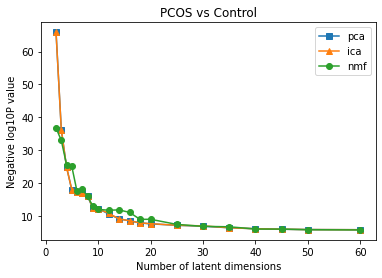

In [47]:
# pcos vs control
pcos_control_df = [pd.DataFrame(y) for x, y in pcos_vs_control_ttest_df.groupby(['z_dim', 'algorithm'], as_index=False)]
top_features_per_algo_across_k = {'pca': [], 'ica': [], 'nmf': []}
for pcdf in pcos_control_df:
    pcdf = pcdf.sort_values(by='neg_log_p', ascending=False)
    top_df = pcdf.iloc[0]
    top_features_per_algo_across_k[top_df['algorithm']].append([top_df['feature_num'], top_df['z_dim'], top_df['neg_log_p']])

plt.figure()
feat_df = top_features_per_algo_across_k['pca']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='pca', marker='s')
feat_df = top_features_per_algo_across_k['ica']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='ica', marker='^')
feat_df = top_features_per_algo_across_k['nmf']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='nmf', marker='o')
plt.legend()
plt.xlabel('Number of latent dimensions')
plt.ylabel('Negative log10P value')
plt.title('PCOS vs Control')
plt.savefig('PCOS_vs_Control_neglogp.png')


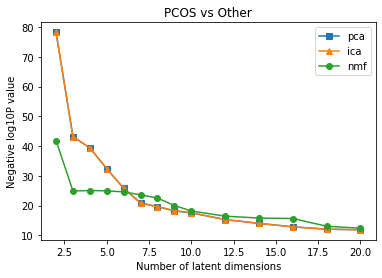

In [48]:
# pcos vs other
pcos_other_df = [pd.DataFrame(y) for x, y in pcos_vs_other_ttest_df.groupby(['z_dim', 'algorithm'], as_index=False)]
top_features_per_algo_across_k = {'pca': [], 'ica': [], 'nmf': []}
for podf in pcos_other_df:
    podf = podf.sort_values(by='neg_log_p', ascending=False)
    top_df = podf.iloc[0]
    top_features_per_algo_across_k[top_df['algorithm']].append([top_df['feature_num'], top_df['z_dim'], top_df['neg_log_p']])

plt.figure()
feat_df = top_features_per_algo_across_k['pca']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='pca', marker='s')
feat_df = top_features_per_algo_across_k['ica']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='ica', marker='^')
feat_df = top_features_per_algo_across_k['nmf']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='nmf', marker='o')
plt.legend()
plt.xlabel('Number of latent dimensions')
plt.ylabel('Negative log10P value')
plt.title('PCOS vs Other')
plt.savefig('PCOS_vs_Other_neglogp.png')


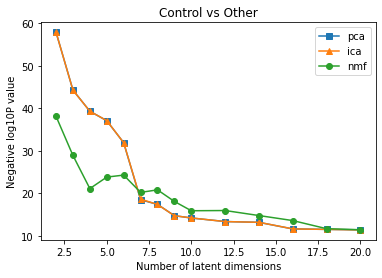

In [49]:
# control vs other
control_other_df = [pd.DataFrame(y) for x, y in control_vs_other_ttest_df.groupby(['z_dim', 'algorithm'], as_index=False)]
top_features_per_algo_across_k = {'pca': [], 'ica': [], 'nmf': []}
for codf in control_other_df:
    codf = codf.sort_values(by='neg_log_p', ascending=False)
    top_df = codf.iloc[0]
    top_features_per_algo_across_k[top_df['algorithm']].append([top_df['feature_num'], top_df['z_dim'], top_df['neg_log_p']])

plt.figure()
feat_df = top_features_per_algo_across_k['pca']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='pca', marker='s')
feat_df = top_features_per_algo_across_k['ica']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='ica', marker='^')
feat_df = top_features_per_algo_across_k['nmf']
dim = [x[1] for x in feat_df]
nlp = [x[2] for x in feat_df]
plt.plot(dim, nlp, label='nmf', marker='o')
plt.legend()
plt.xlabel('Number of latent dimensions')
plt.ylabel('Negative log10P value')
plt.title('Control vs Other')
plt.savefig('Control_vs_Other_neglogp.png')
